In [1]:

import jax
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '3'
print(jax.local_devices())



import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax.scipy as scipy

from jax import random


import matplotlib.pyplot as plt

from utils_rough_pde import *
from utils_elliptic_coef import *

from scipy import integrate

import time

from jax.numpy import fft

from tqdm import tqdm

[cuda(id=0)]


In [2]:
def compute_1d_error(pred, u, x):
    norm_u = jnp.sqrt(integrate.trapezoid(u**2, x))
    norm_diff = jnp.sqrt(integrate.trapezoid((pred - u)**2, x))
    return norm_diff, norm_diff/norm_u

To solve 
$$
Lu = f
$$
we will use the fact that 

\begin{align}
   ||Lu -f ||^2 = \mathbb{E}_{\varphi \sim \mu}[|\langle Lu - f,\varphi\rangle|^2]
\end{align}

We will solve the elliptic PDE with Dirichlet bc
\begin{aligned}
-\nu\Delta u + u &= \xi \\
u &= 0
\end{aligned}


If 
$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Then 
$$
\xi =  \sqrt{\frac{2}{L}} \sum_{i}^\infty  \Big(\nu\frac{n^2\pi^2}{L^2} + 1\Big)c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Conversely, if 
$$
\xi =  \sqrt{\frac{2}{L}} \sum_{i}^\infty \xi_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

then 

$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty \frac{\xi_i}{(\nu\frac{n^2\pi^2}{L^2} + 1\Big)} \sin\Big(\frac{n\pi x}{L}\Big)
$$

Iou casem we will have the domain be $[0,1]$ and so $L = 1.0$. Therefore

\begin{aligned}
\xi &=   \sqrt{2} \sum_{i}^\infty \xi_j \sin\Big(j\pi x\Big) \\
u &=  \sqrt{2}\sum_{j}^\infty \frac{\xi_j}{(\nu\frac{j^2\pi^2}{L^2} + 1\Big)}\sin\Big(j\pi x\Big)
\end{aligned}

In this case $\xi \in H^{-s}, s > 1/2$. Hence we need to sample from $\phi \sim \mathcal{N}(0, C^{\frac{1}{2} + \delta})$

In [3]:
plt.style.use('plot_style-Examples.txt')
#plt.style.use('default')

# 16:9 aspect ratio
width = 4
height = width * 3 / 4

In [4]:
from importlib import reload
import utils_DST

utils_DST = reload(utils_DST)
from utils_DST import discrete_sine_transform, compute_sine_coefficients, vmap_compute_sine_coef

In [129]:
key = random.PRNGKey(635)
nu = 0.1


n_coef = 2**15
upper = 1.0
lower = 0.0
boundary = jnp.array([lower, upper])
boundary_conditions = jnp.array([0.0, 0.0])

domain_finest = jnp.linspace(lower,upper,n_coef+1, endpoint=False)[1:] # Do not include 0 or 1!
print(n_coef)

frequencies = jnp.arange(0, n_coef) + 1

f_decay = 1.0
coef_f = jnp.hstack([random.normal(key, shape= (n_coef,))])/(frequencies**(f_decay))
coef_u = coef_f/(nu*frequencies**2*jnp.pi**2 + 1)

f_values = discrete_sine_transform(coef_f)
u_values = discrete_sine_transform(coef_u)

32768


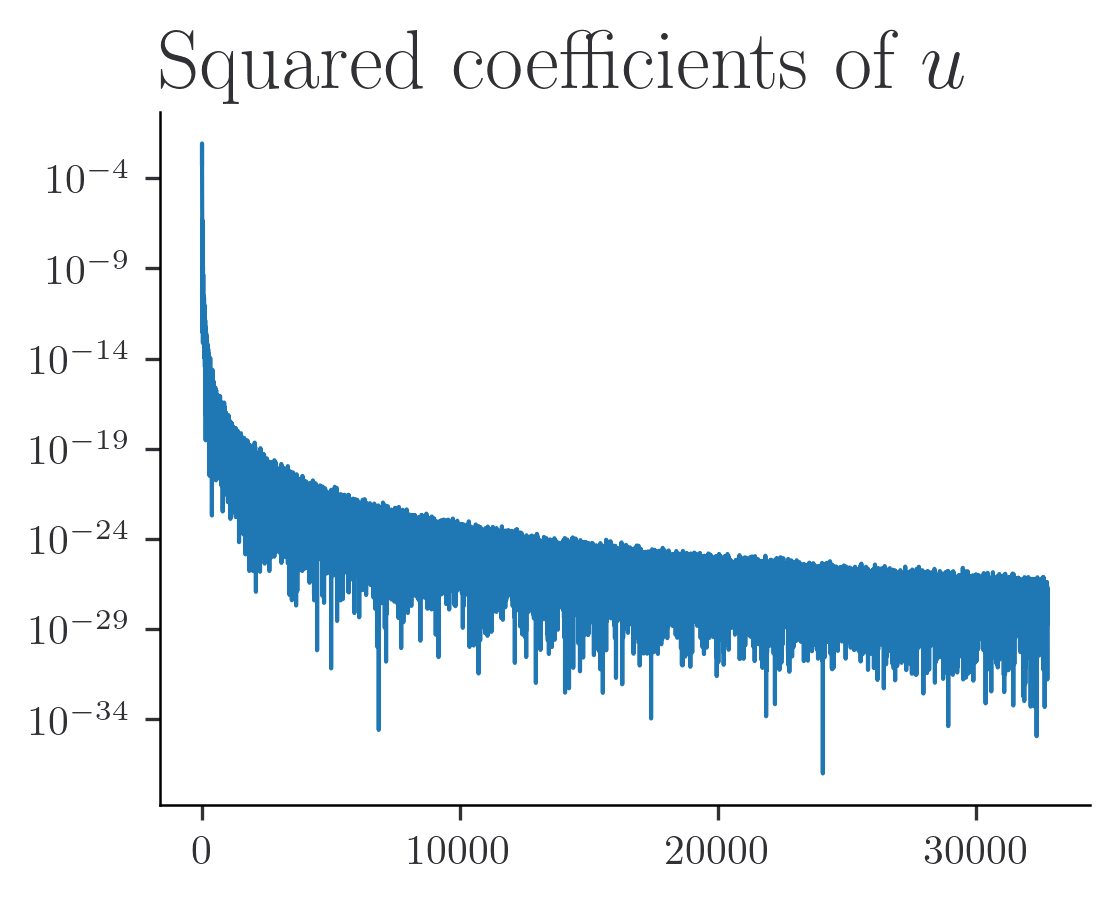

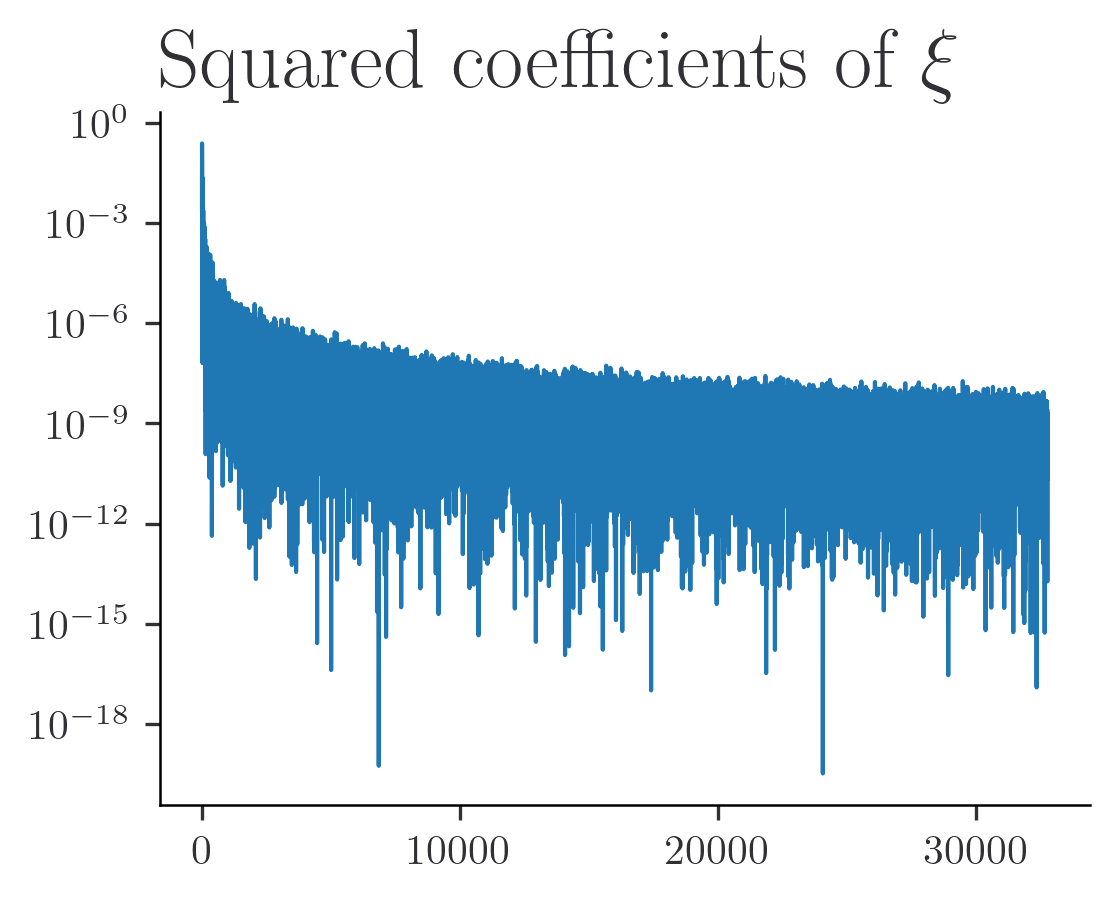

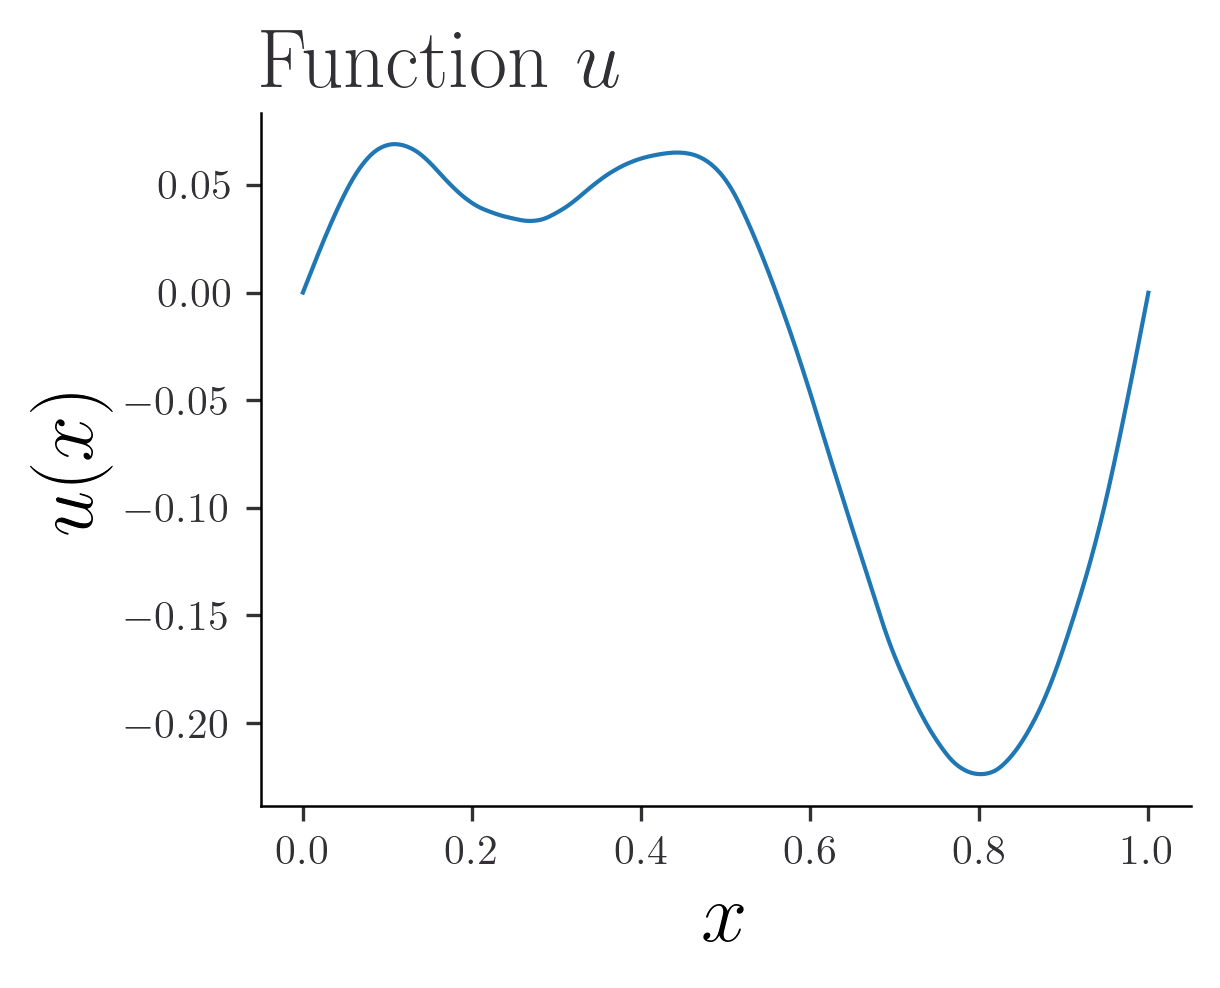

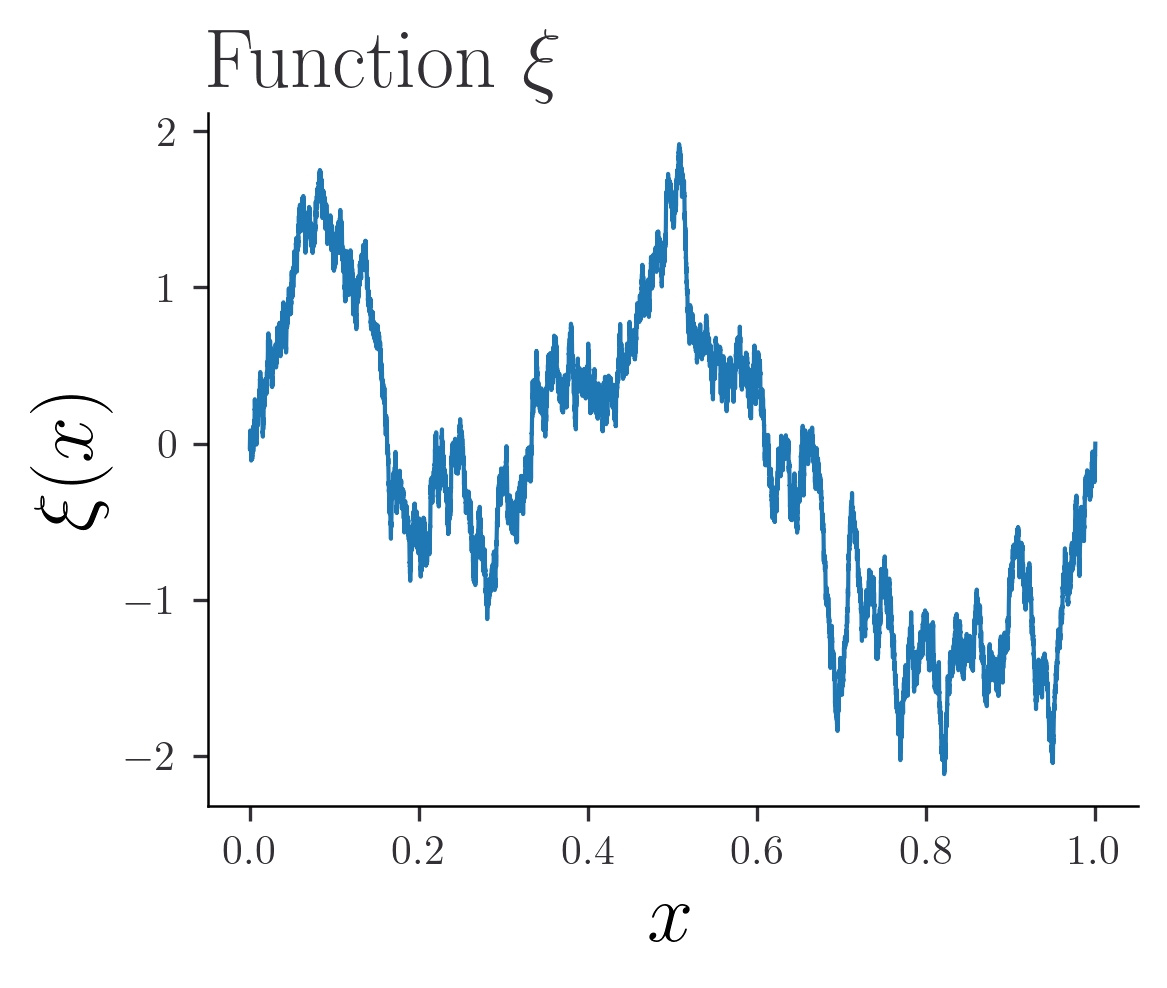

In [130]:
# Plot both the coeffients of u and f in 2 subplots
fig = plt.figure(figsize=(width, height))
plt.plot(coef_u**2)
plt.yscale('log')
plt.title(r'Squared coefficients of $u$')


plt.show()

fig = plt.figure(figsize=(width, height))
plt.plot(coef_f**2)
plt.yscale('log')
plt.title(r'Squared coefficients of $\xi$')
plt.show()

# Create 2 plots for the  function u and f
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, u_values)
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")

fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, f_values)
plt.xlabel(r"$x$")
plt.ylabel(r"$\xi(x)$")
plt.title(r"Function $\xi$")

plt.gca().autoscale()  # This applies to the current axis

plt.show()

# Building our RFF

In [103]:
from jax import grad, jacfwd, jacrev

In [104]:
# Draw random samples for the RF part
n_samples = 500
print('Number of samples: ', n_samples)
d_in = 1

key = random.PRNGKey(0)
key, subkey = random.split(key)
sigma_rff = 10.0
random_features = random.normal(subkey, shape = (n_samples, d_in))*sigma_rff

# d_in = 1
# nu = 1.0
# sigma_rff = 10.0
# key = random.PRNGKey(0)
# key, subkey = random.split(key)
# random_features = random.t(subkey, df  = nu*2, shape = (n_samples, d_in))*sigma_rff


def feature(input, xi):
    input = jnp.dot(input, xi)
    return jnp.vstack([jnp.cos(input), jnp.sin(input)])

vmap_feature = vmap(feature, in_axes=(None, 0))

def feature_map(x, random_features):
    n_samples = random_features.shape[0]
    return jnp.squeeze(vmap_feature(x, random_features)).flatten()


def L_feature(input, xi, nu):
    return -nu*jacrev(jacrev(feature))(input, xi) + feature(input, xi)

def L_feature_map(x, random_features, nu):
    n_samples = random_features.shape[0]
    return jnp.squeeze(vmap(L_feature, in_axes=(None, 0, None))(x, random_features, nu)).flatten()

vmap_feature_map = jit(vmap(feature_map, in_axes=(0, None)))
vmap_L_feature_map = jit(vmap(L_feature_map, in_axes=(0, None, None)))

Number of samples:  500


In [105]:
def solve_qp(Q, E, c, constraints, reg = 0.0):
    n_constraints = E.shape[0]
    n_variables = Q.shape[0]
    # Form the QP
    A = jnp.block([[Q + reg*jnp.eye(n_variables), E.T], [E, jnp.zeros((n_constraints,n_constraints))]])
    b = jnp.block([-c, constraints])

    # Solve the QP
    x = scipy.linalg.solve(A, b)
    return x[:n_variables]


In [106]:
2**10

1024

In [191]:
m_full = 2**10


key = random.PRNGKey(0)


x_eval = jnp.linspace(lower, upper,m_full +1, endpoint=False)[1:]
L_psi = vmap_L_feature_map(x_eval, random_features, nu)
L_psi_fourier =vmap_compute_sine_coef(L_psi.T).T
Psi_bc = vmap_feature_map(boundary, random_features)


f_observed = coef_f[:m_full]
bc = jnp.array([0.0, 0.0])

s = 0.2

w = frequencies[:m_full]**s


beta = jnp.zeros(n_samples*2) # This is the coefficients of the solution

n_iter = 1

reg = 1e-10
for i in range(n_iter):

    # Draw a random projection 
    key, subkey = random.split(key)

    phi_proj =  jnp.diag(w)#jnp.eye(m_full)
    r_proj = phi_proj@f_observed

    # Form the measurement matrix 
    A_l = phi_proj@L_psi_fourier

    Theta = A_l.T@A_l

    c = -(A_l.T@r_proj)
    beta = solve_qp(Theta, Psi_bc, c, bc, reg = reg)
    #beta = solve_qp(L_psi_fourier, Psi_bc, f_observed, bc)



    

In [192]:
# x_eval = jnp.linspace(lower, upper,m_full +1, endpoint=False)[1:]
# pred = vmap_feature_map(x_eval, random_features)@beta

# u_eval = u_values[::int(n_coef//m_full)]

In [193]:
jnp.mean(jnp.abs(phi_proj@L_psi_fourier@beta - phi_proj@f_observed))

Array(0.00914659, dtype=float64)

In [194]:
compute_1d_error(vmap_feature_map(domain_finest, random_features)@beta, u_values, domain_finest) 

(Array(0.00030769, dtype=float64), Array(0.00278246, dtype=float64))

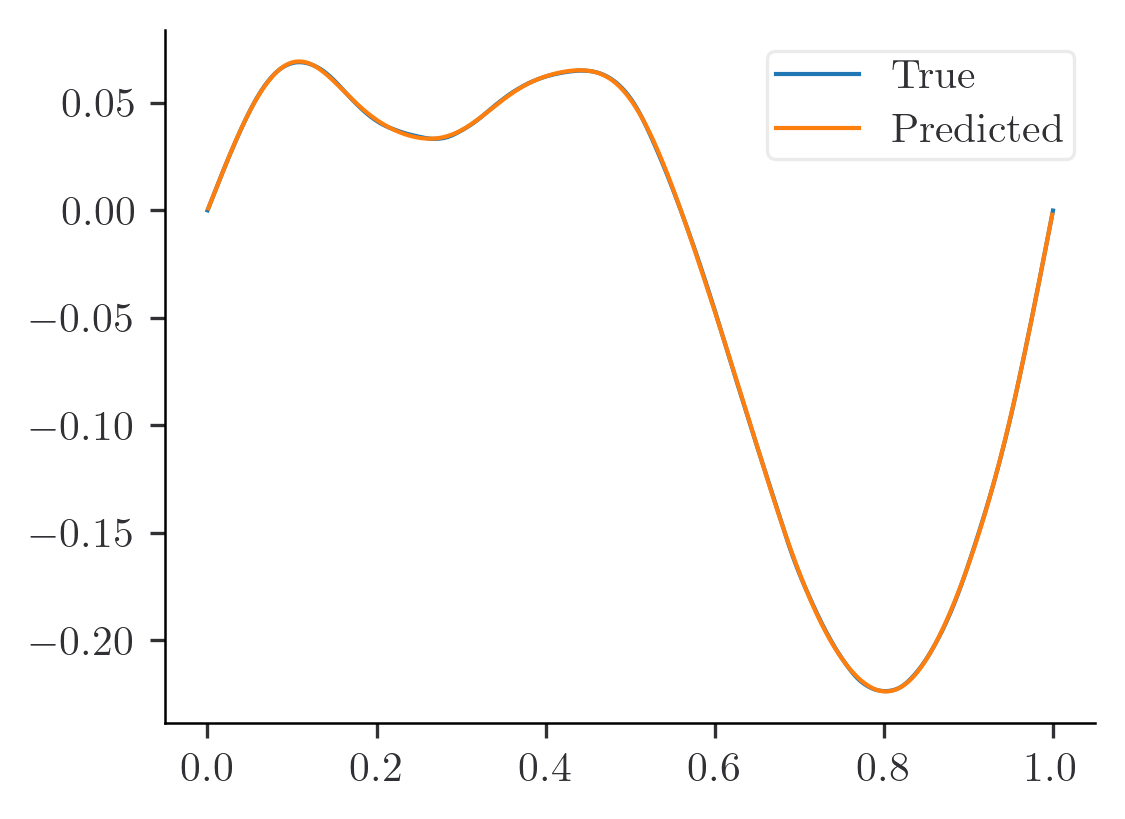

In [196]:
Psi = vmap_feature_map(x_eval, random_features)
pred = Psi@beta

fig = plt.figure(figsize=(width, height))   
plt.plot(domain_finest, u_values, label = 'True')
plt.plot(x_eval, pred, label = 'Predicted')
plt.legend()
plt.show()

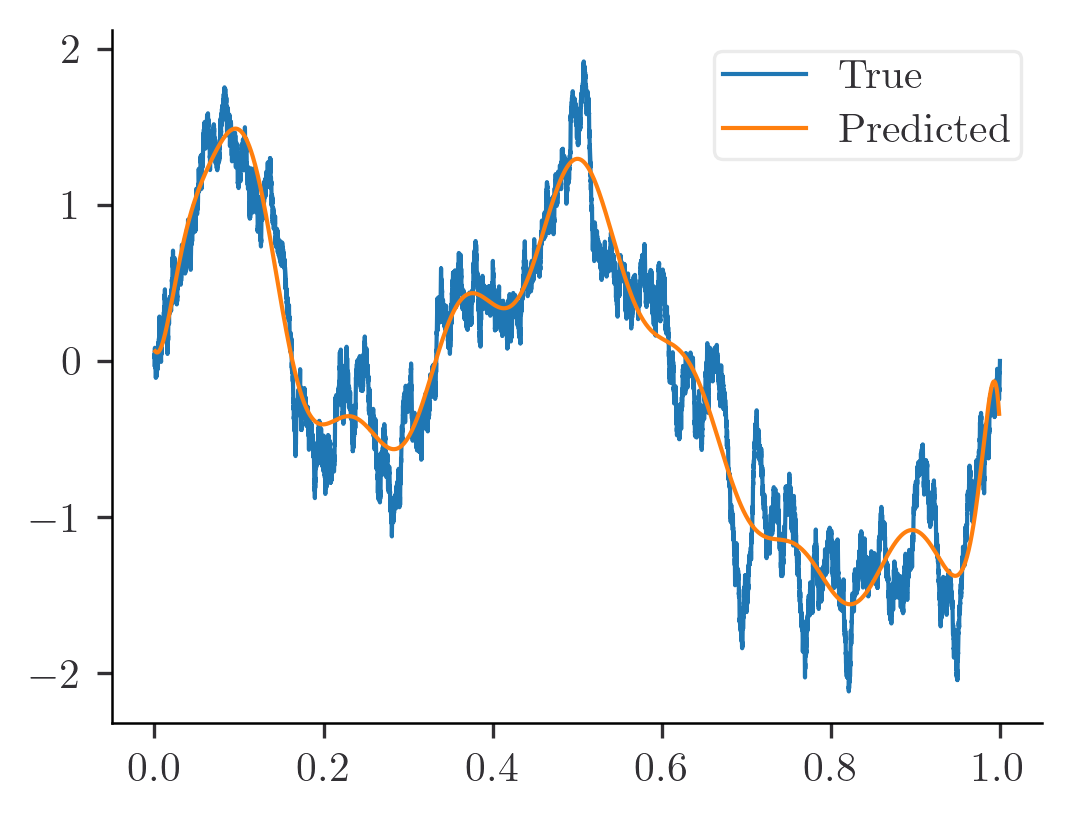

In [197]:

pred_L = L_psi@beta

fig = plt.figure(figsize=(width, height))   
plt.plot(domain_finest, f_values, label = 'True')
plt.plot(x_eval, pred_L, label = 'Predicted')
plt.legend()
plt.show()

# Sketch and solve

In [198]:
frequencies

Array([    1,     2,     3, ..., 32766, 32767, 32768], dtype=int64)

In [296]:
m = n_coef
n_proj = int(m_full/8)

key = random.PRNGKey(0)


x_eval = jnp.linspace(lower, upper,m +1, endpoint=False)[1:]
L_psi = vmap_L_feature_map(x_eval, random_features, nu)
L_psi_fourier =vmap_compute_sine_coef(L_psi.T).T

Psi_bc = vmap_feature_map(boundary, random_features)
Psi_error = vmap_feature_map(domain_finest, random_features)

f_observed = coef_f[:m]
bc = jnp.array([0.0, 0.0])
delta = 1.0
s = -1.0


beta = jnp.zeros(n_samples*2) # This is the coefficients of the solution

n_iter = 1
reg= 1e-10

residual_history = []
error_history = []
for i in tqdm(range(n_iter)):

    # Draw a random projection 
    key, subkey = random.split(key)

    phi_proj = random.normal(subkey, shape = (n_proj, m))*frequencies**s #random.normal(subkey, shape = (n_proj, m))/(jnp.arange(1, m+1)**((1+delta)/2))
    r_proj = phi_proj@(f_observed - L_psi_fourier@beta)

    # Form the measurement matrix 
    A_l = phi_proj@L_psi_fourier

    Theta = A_l.T@A_l

    c = -(Theta@beta + A_l.T@r_proj)
    beta = solve_qp(Theta, Psi_bc, c, bc, reg = reg)
    #beta = solve_qp(L_psi_fourier, Psi_bc, f_observed, bc)

    res = jnp.mean(jnp.abs(phi_proj@L_psi_fourier@beta - phi_proj@f_observed))
    error = compute_1d_error(Psi_error@beta, u_values, domain_finest)[-1]

    residual_history.append(res)
    error_history.append(error)
    



    

100%|██████████| 1/1 [00:00<00:00,  9.64it/s]


In [297]:
compute_1d_error(vmap_feature_map(domain_finest, random_features)@beta, u_values, domain_finest) 

(Array(0.00100583, dtype=float64), Array(0.00909572, dtype=float64))

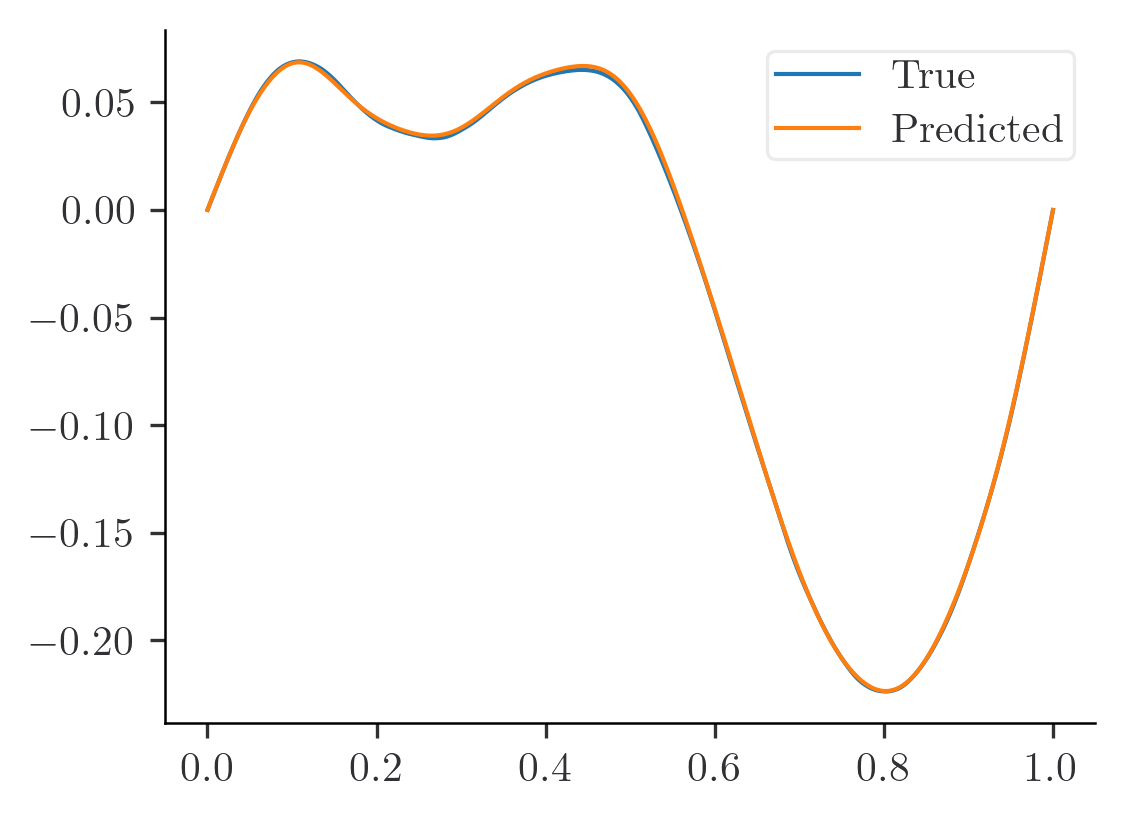

In [298]:
Psi = vmap_feature_map(x_eval, random_features)
pred = Psi@beta

fig = plt.figure(figsize=(width, height))   
plt.plot(domain_finest, u_values, label = 'True')
plt.plot(x_eval, pred, label = 'Predicted')
plt.legend()
plt.show()

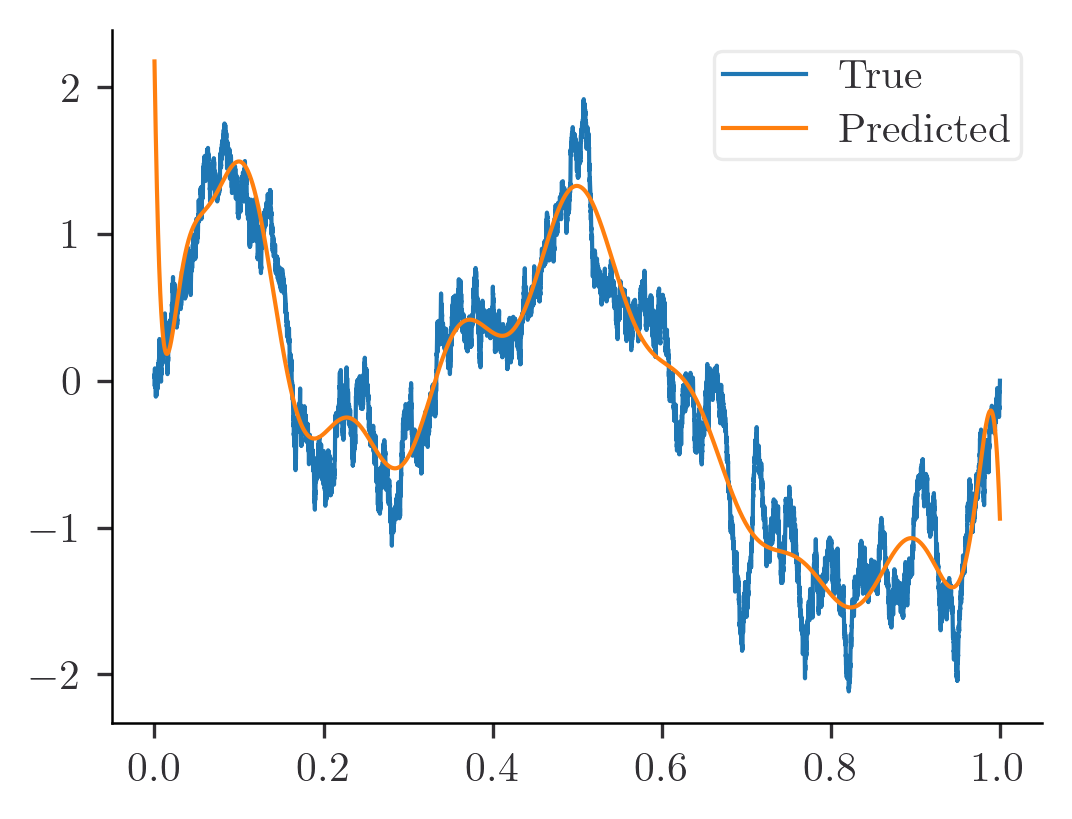

In [299]:
pred_L = L_psi@beta

fig = plt.figure(figsize=(width, height))   
plt.plot(domain_finest, f_values, label = 'True')
plt.plot(x_eval, pred_L, label = 'Predicted')
plt.legend()
plt.show()

# Stochastic Gauss-Newton

In [289]:
lr = 0.1

In [290]:
m = n_coef
n_proj = int(m_full/8)

key = random.PRNGKey(0)


x_eval = jnp.linspace(lower, upper,m +1, endpoint=False)[1:]
L_psi = vmap_L_feature_map(x_eval, random_features, nu)
L_psi_fourier =vmap_compute_sine_coef(L_psi.T).T

Psi_bc = vmap_feature_map(boundary, random_features)
Psi_error = vmap_feature_map(domain_finest, random_features)

f_observed = coef_f[:m]
bc = jnp.array([0.0, 0.0])
delta = 1.0
s = -1.0


beta = jnp.zeros(n_samples*2) # This is the coefficients of the solution

n_iter = 300
reg= 1e-10

residual_history = []
error_history = []
for i in tqdm(range(n_iter)):

    # Draw a random projection 
    key, subkey = random.split(key)

    phi_proj =  random.normal(subkey, shape = (n_proj, m))*frequencies**s #random.normal(subkey, shape = (n_proj, m))/(jnp.arange(1, m+1)**((1+delta)/2))
    r_proj = phi_proj@(f_observed - L_psi_fourier@beta)

    # Form the measurement matrix 
    A_l = phi_proj@L_psi_fourier

    Theta = A_l.T@A_l

    c = -(A_l.T@r_proj)
    increment = solve_qp(Theta, Psi_bc, c, bc, reg = reg)
    beta = beta + lr*increment

    res = jnp.mean(jnp.abs(phi_proj@L_psi_fourier@beta - phi_proj@f_observed))
    error = compute_1d_error(Psi_error@beta, u_values, domain_finest)[-1]

    residual_history.append(res)
    error_history.append(error)
    



    

100%|██████████| 300/300 [00:08<00:00, 34.66it/s]


In [301]:
n_proj

128

In [291]:
compute_1d_error(vmap_feature_map(domain_finest, random_features)@beta, u_values, domain_finest) 

(Array(0.000246, dtype=float64), Array(0.00222458, dtype=float64))

In [302]:
jnp.abs(0.000246 - 0.00030769)/jnp.abs(0.00030769)

Array(0.200494, dtype=float64, weak_type=True)

In [292]:
# Check the boundary conditions
Psi_bc@beta

Array([-2.41470843e-10, -6.82121026e-13], dtype=float64)

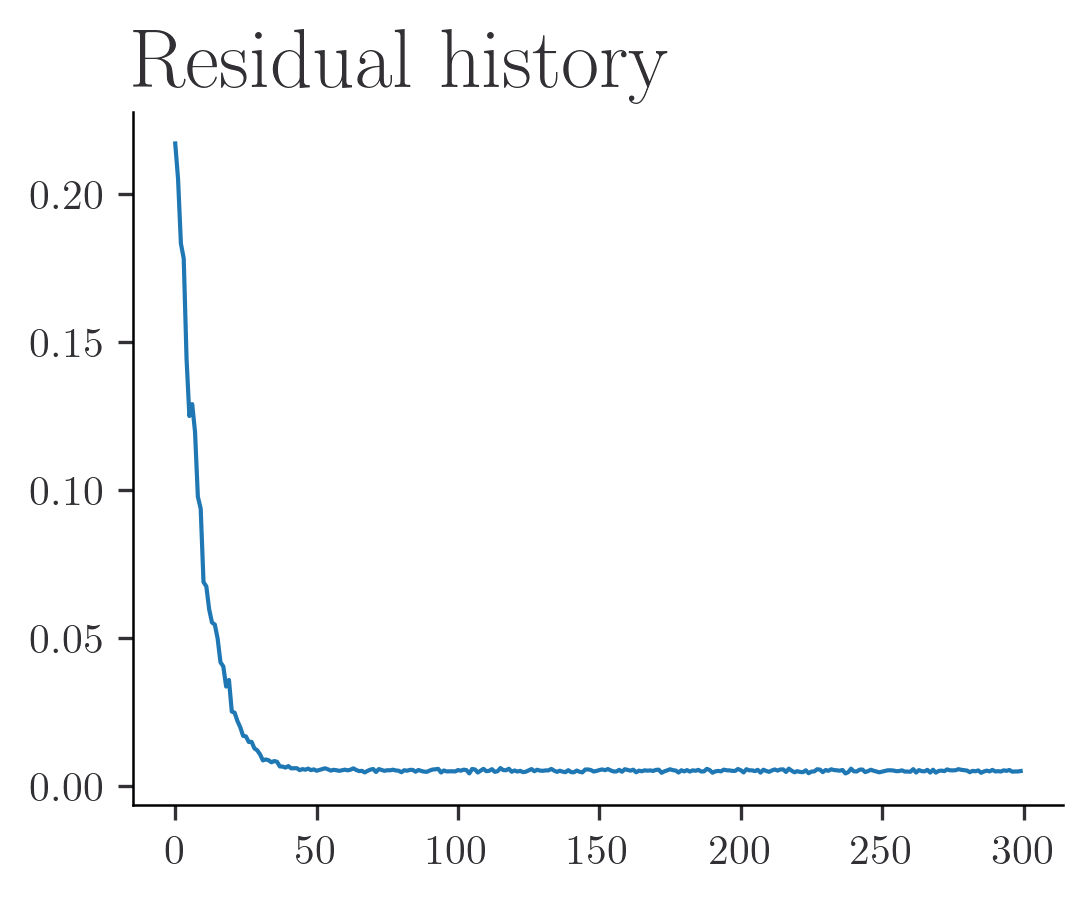

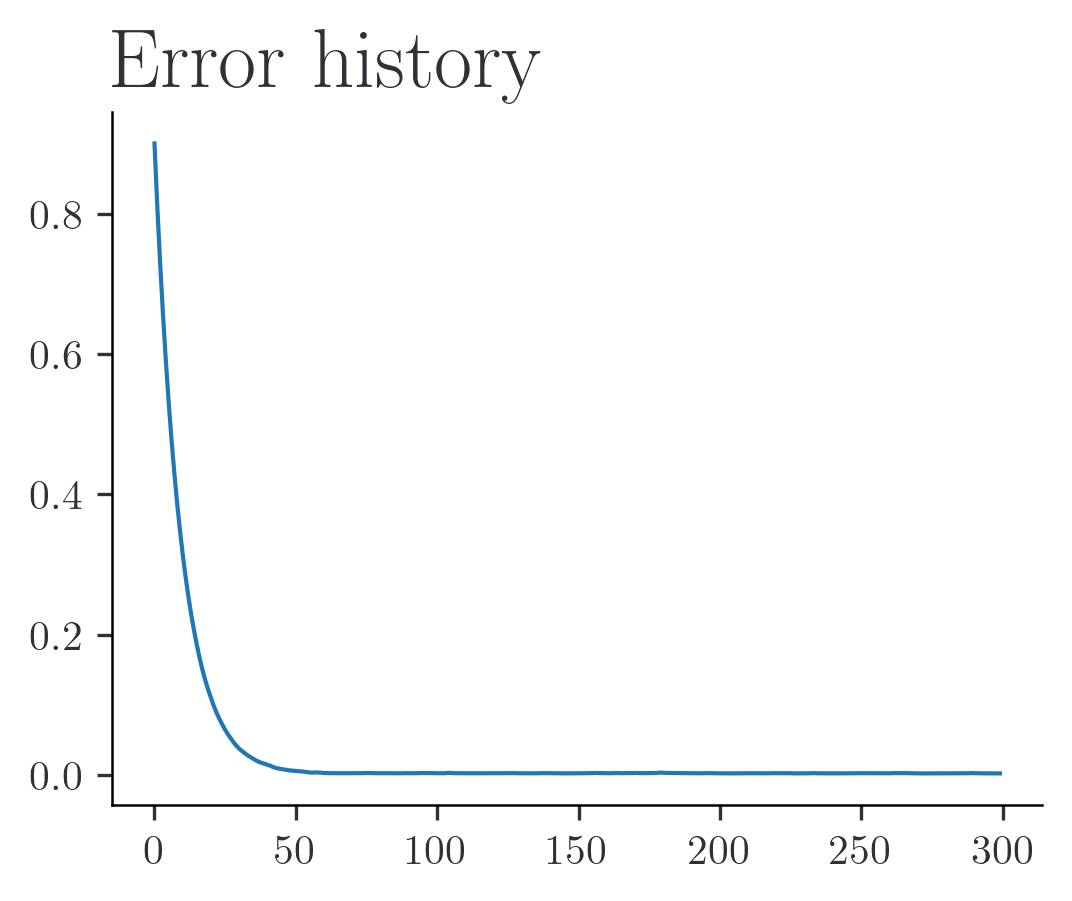

In [293]:
fig = plt.figure(figsize=(width, height)) 
plt.plot(residual_history)
plt.title("Residual history")
plt.show()

fig = plt.figure(figsize=(width, height)) 
plt.plot(error_history)
plt.title("Error history")
plt.show()

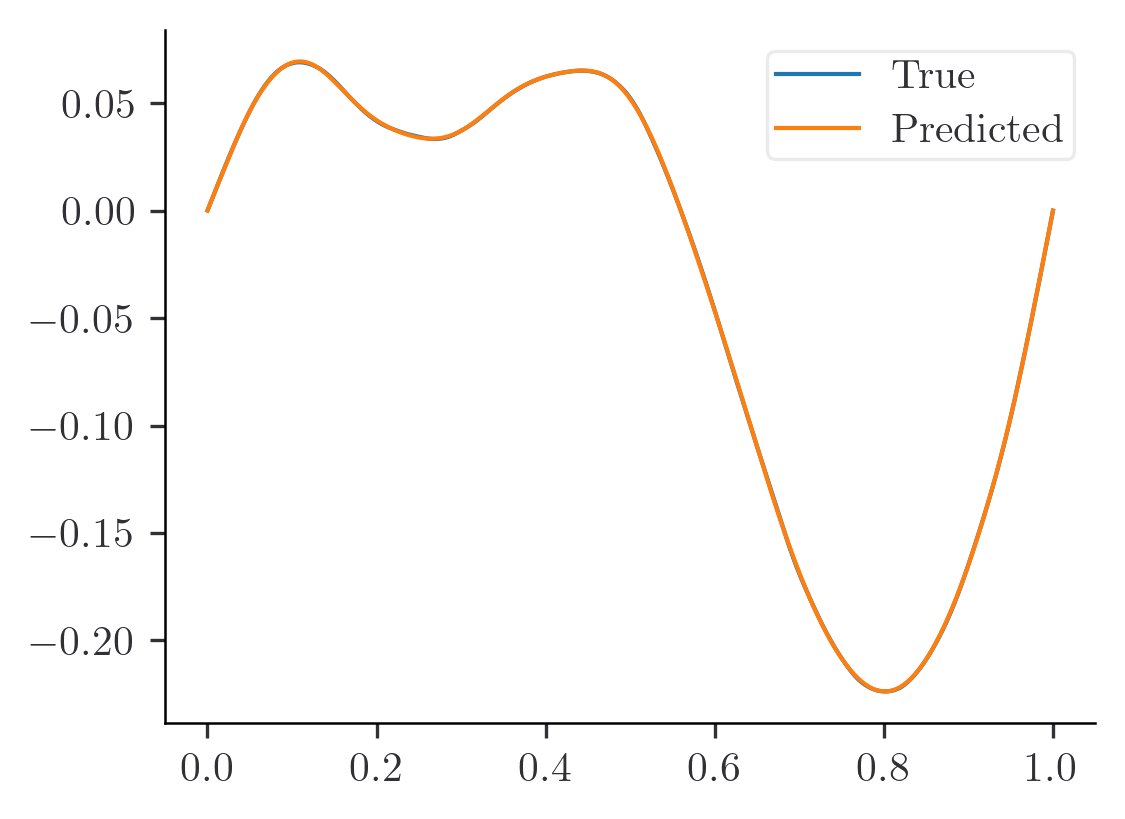

In [294]:
Psi = vmap_feature_map(x_eval, random_features)
pred = Psi@beta

fig = plt.figure(figsize=(width, height))   
plt.plot(domain_finest, u_values, label = 'True')
plt.plot(x_eval, pred, label = 'Predicted')
plt.legend()
plt.show()

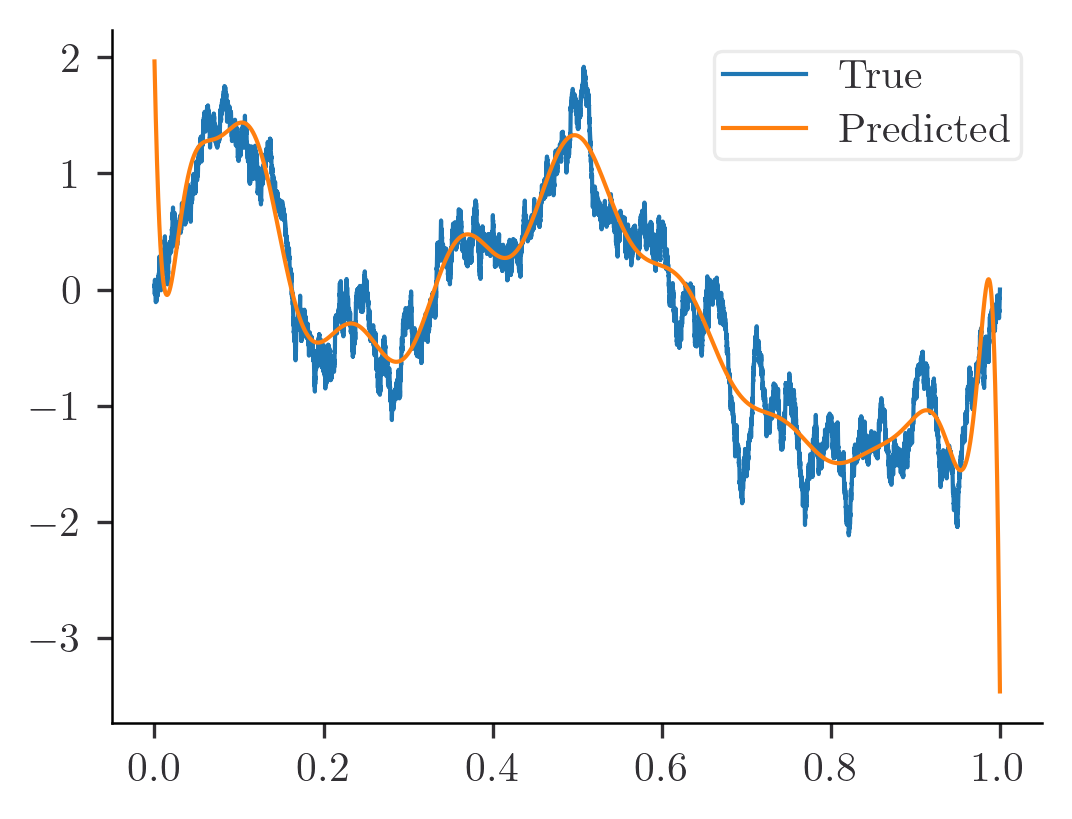

In [295]:
pred_L = L_psi@beta

fig = plt.figure(figsize=(width, height))   
plt.plot(domain_finest, f_values, label = 'True')
plt.plot(x_eval, pred_L, label = 'Predicted')
plt.legend()
plt.show()

# ADAM optimizer (this does not work at all lol)

In [62]:
from optax import adamw, sgd
import optax

In [67]:
m = n_coef
n_proj = int(m_full/4)

key = random.PRNGKey(0)


x_eval = jnp.linspace(lower, upper,m +1, endpoint=False)[1:]
L_psi = vmap_L_feature_map(x_eval, random_features, nu)
L_psi_fourier =vmap_compute_sine_coef(L_psi.T).T

Psi_bc = vmap_feature_map(boundary, random_features)
Psi_error = vmap_feature_map(domain_finest, random_features)

f_observed = coef_f[:m]
bc = jnp.array([0.0, 0.0])
delta = 0.5


beta = jnp.zeros(n_samples*2) # This is the coefficients of the solution
optimizer = optax.adamw(1e-3, weight_decay = 0.0)
opt_state = optimizer.init(beta)

n_iter = 100
reg= 1e-10

residual_history = []
error_history = []
for i in tqdm(range(n_iter)):

    # Draw a random projection 
    key, subkey = random.split(key)

    phi_proj =  random.normal(subkey, shape = (n_proj, m))/(jnp.arange(1, m+1)**((1+delta)/2))
    r_proj = phi_proj@(f_observed - L_psi_fourier@beta)

    # Form the measurement matrix 
    A_l = phi_proj@L_psi_fourier

    Theta = A_l.T@A_l

    c = -(A_l.T@r_proj)
    increment = solve_qp(Theta, Psi_bc, c, bc, reg = reg)
    #beta = beta + lr*increment
    updates, opt_state = optimizer.update(increment, opt_state, beta)
    beta = optax.apply_updates(beta, updates)

    res = jnp.mean(jnp.abs(phi_proj@L_psi_fourier@beta - phi_proj@f_observed))
    error = compute_1d_error(Psi_error@beta, u_values, domain_finest)[-1]

    residual_history.append(res)
    error_history.append(error)
    



    

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:06<00:00, 16.63it/s]


In [68]:
compute_1d_error(vmap_feature_map(domain_finest, random_features)@beta, u_values, domain_finest) 

(Array(1.66047298, dtype=float64), Array(30.03135621, dtype=float64))

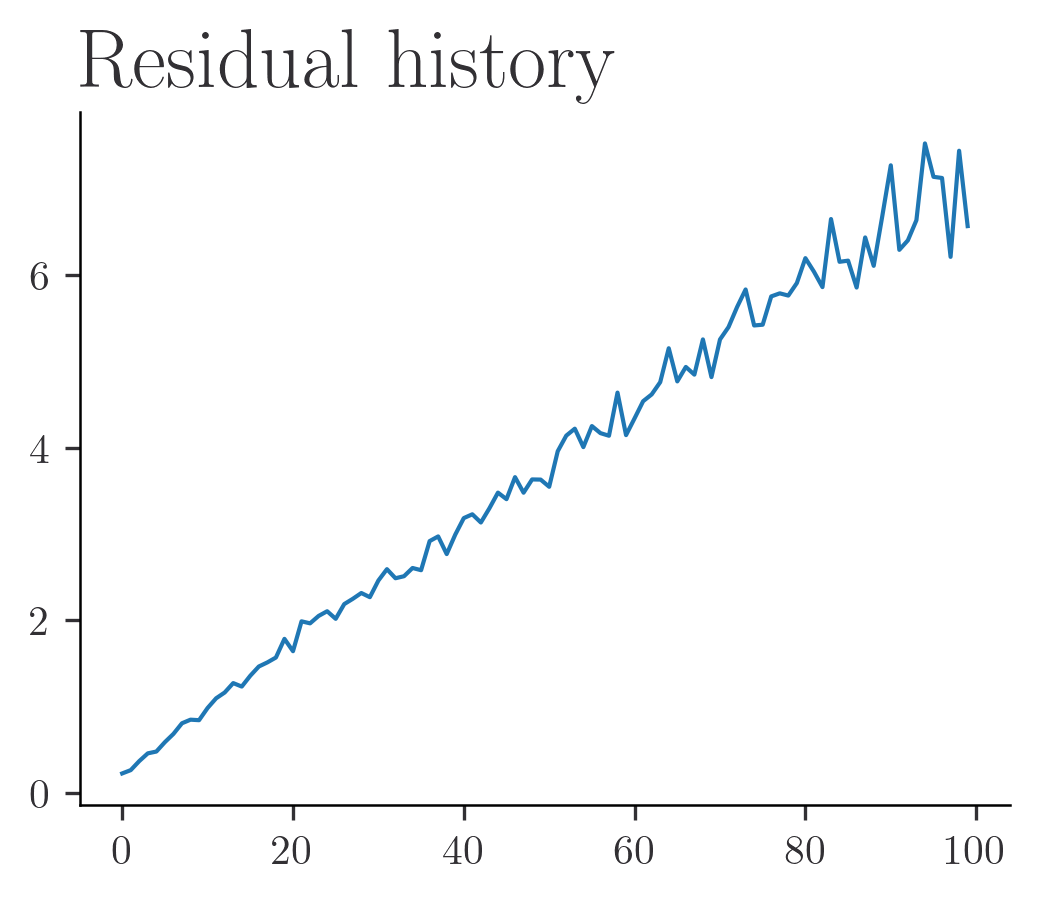

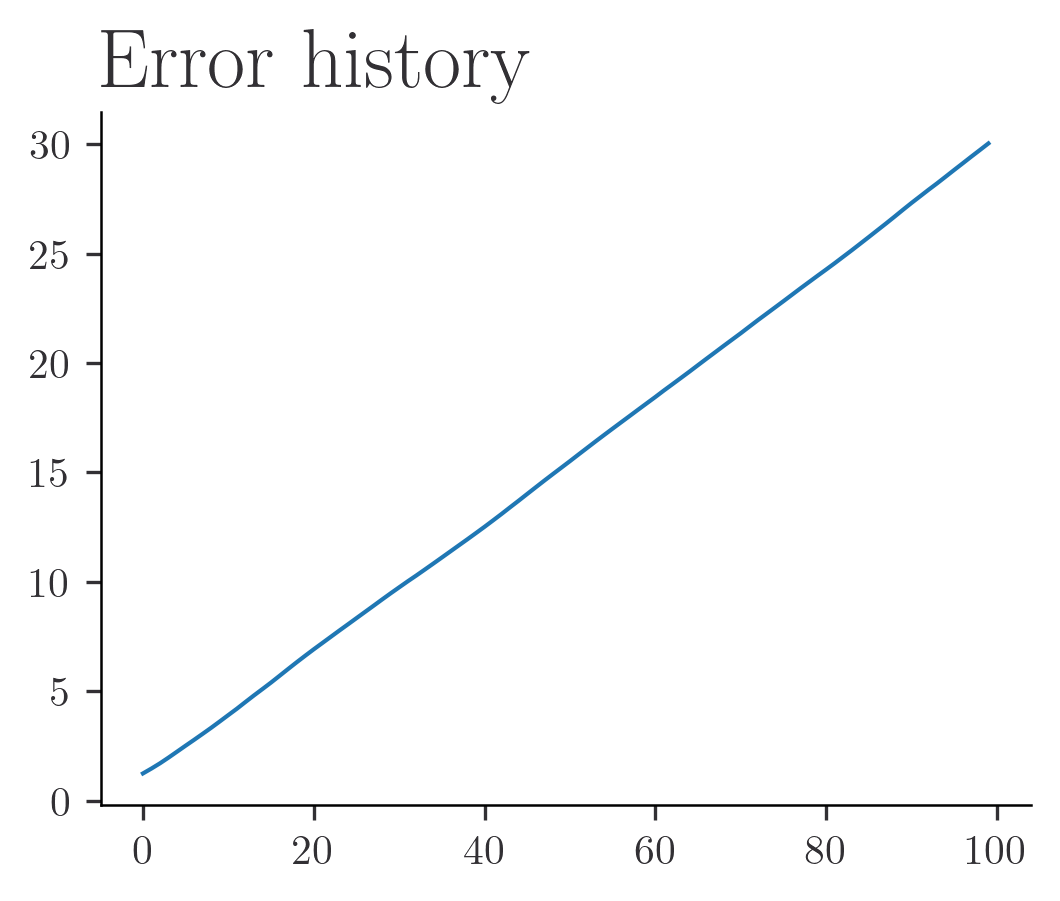

In [69]:
fig = plt.figure(figsize=(width, height)) 
plt.plot(residual_history)
plt.title("Residual history")
plt.show()

fig = plt.figure(figsize=(width, height)) 
plt.plot(error_history)
plt.title("Error history")
plt.show()

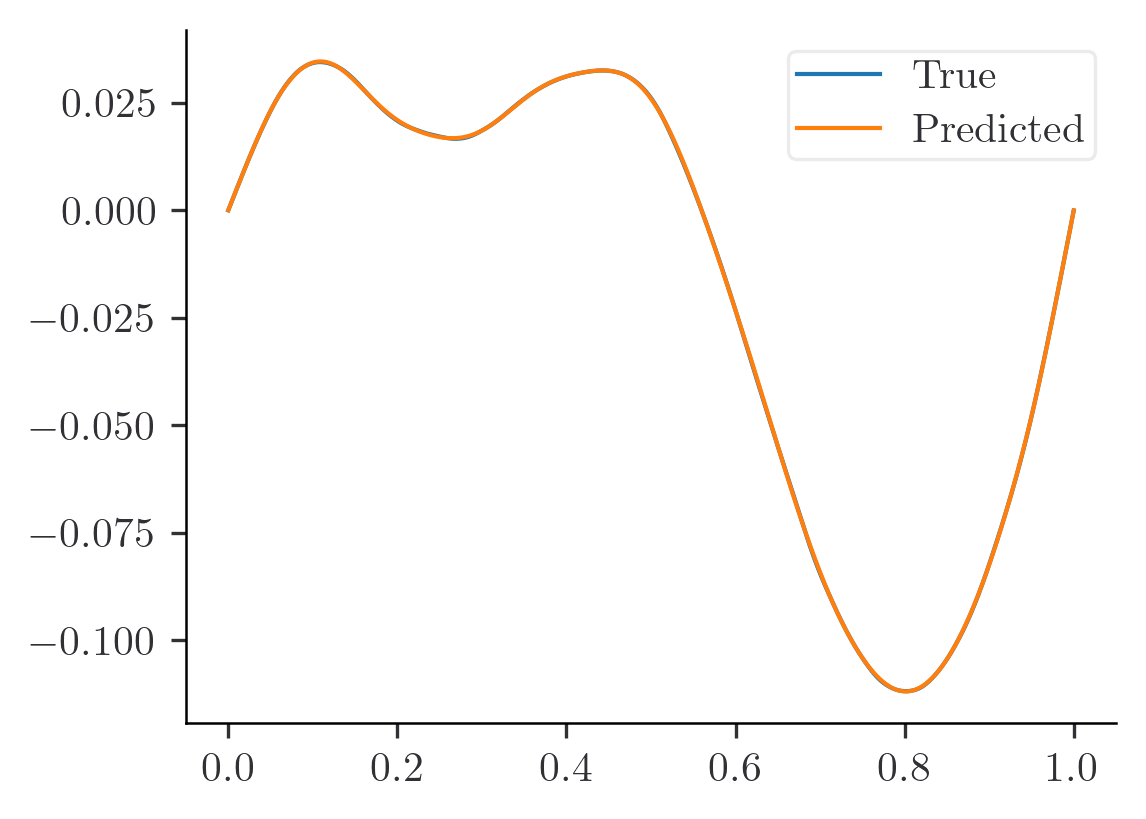

In [ ]:
Psi = vmap_feature_map(x_eval, random_features)
pred = Psi@beta

fig = plt.figure(figsize=(width, height))   
plt.plot(domain_finest, u_values, label = 'True')
plt.plot(x_eval, pred, label = 'Predicted')
plt.legend()
plt.show()

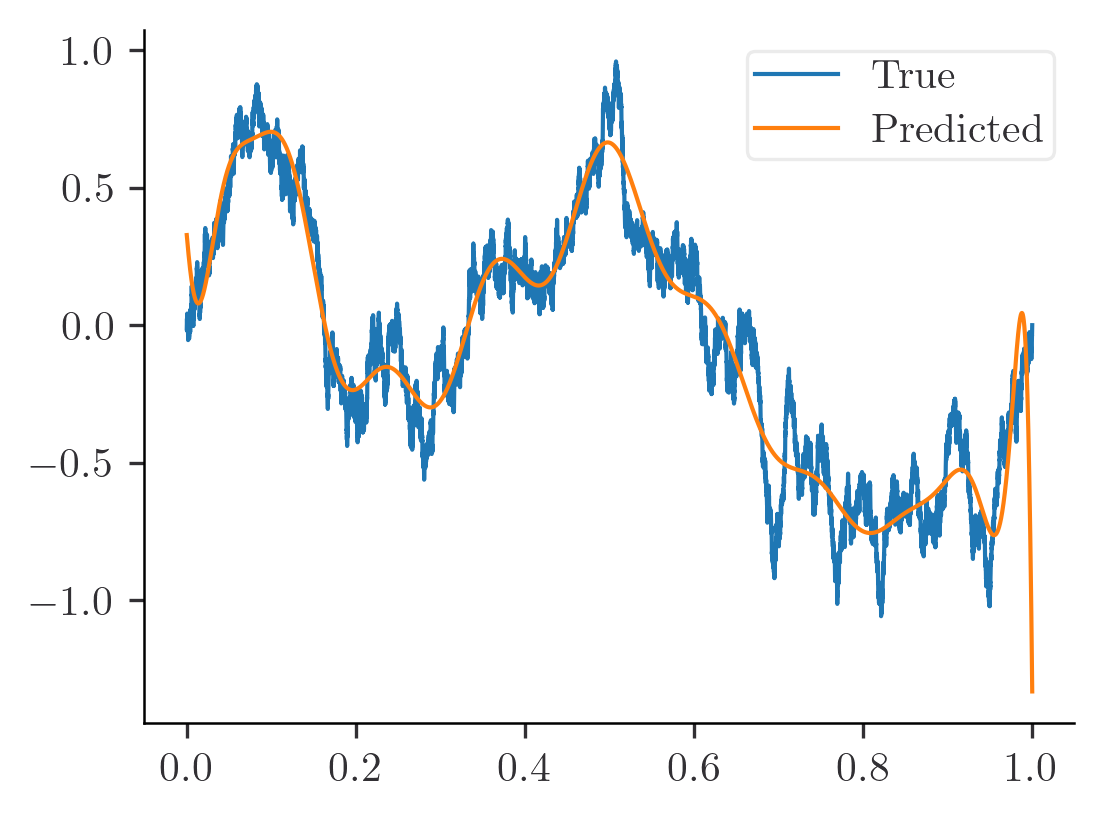

In [ ]:
pred_L = L_psi@beta

fig = plt.figure(figsize=(width, height))   
plt.plot(domain_finest, f_values, label = 'True')
plt.plot(x_eval, pred_L, label = 'Predicted')
plt.legend()
plt.show()

# SGD

In [159]:
from optax import adamw, sgd
from jax import value_and_grad
import optax

In [160]:
beta = random.normal(random.PRNGKey(0), shape =( n_samples * 2,))

In [161]:
m_full

1024

In [162]:
m = n_coef
n_proj = 64

key = random.PRNGKey(0)


x_eval = jnp.linspace(lower, upper,m +1, endpoint=False)[1:]
L_psi = vmap_L_feature_map(x_eval, random_features, nu)
L_psi_fourier =vmap_compute_sine_coef(L_psi.T).T

Psi_bc = vmap_feature_map(boundary, random_features)
Psi_error = vmap_feature_map(domain_finest, random_features)

f_observed = coef_f[:m]
bc = jnp.array([0.0, 0.0])
delta = 0.5

In [163]:
def loss_fn(beta, f_observed, phi_proj, L_psi_fourier, Psi_bc, boundary_conditions):
    r_proj = phi_proj@(f_observed)
    pred = phi_proj@L_psi_fourier@beta

    return jnp.mean((pred - r_proj)**2) + jnp.mean((Psi_bc@beta - boundary_conditions)**2)

loss_fn(beta, f_observed, phi_proj, L_psi_fourier, Psi_bc, bc)

Array(11510.16369992, dtype=float64)

In [164]:
loss, grads = value_and_grad(loss_fn)(beta, f_observed, phi_proj, L_psi_fourier, Psi_bc, bc)
loss, grads

(Array(11510.16369992, dtype=float64),
 Array([-5.48276165e+02, -3.18227342e+02, -5.57593658e+02,  5.53771158e+01,
        -2.08045033e+02, -4.92309445e+02, -1.76056567e+00, -5.14150241e+01,
         2.46440295e+01, -1.86911876e+01,  2.43922220e+01,  1.59727107e+01,
        -4.99158485e+01, -2.12051018e+02, -1.56893892e+00,  5.17857182e+01,
        -5.31060628e+02, -3.66264850e+02,  2.74384899e+00, -5.59369127e+01,
         7.58877684e-01,  1.86523712e+00,  1.09217153e+01,  7.02131774e+01,
        -4.76267048e+02, -3.10347638e+02, -4.79634597e+02, -4.62191751e+02,
        -3.03002802e+02,  4.48210630e+02, -5.97386903e+01, -2.19014507e+02,
        -5.23536370e+02, -3.94527199e+01,  1.43229222e+01, -8.28249370e+01,
         3.25261121e+00,  5.04679919e+01,  5.26902342e-01,  1.45337472e+00,
         3.21283282e+00,  5.04792921e+01,  3.00060756e+02,  6.47434365e+02,
         8.64044986e+00, -4.82094468e+01, -2.46853678e+02,  2.55378210e+02,
        -5.06096666e+02, -7.15482114e+01, -6.3333

In [190]:
# Define the learning rate scheduler
initial_learning_rate = 1e-3
num_epochs = 1e5
decay_steps = num_epochs/10
decay_rate = 0.9

learning_rate_schedule = optax.exponential_decay(
    init_value=initial_learning_rate,
    transition_steps=decay_steps,
    decay_rate=decay_rate,
    transition_begin=0,
    staircase=False
)
optimizer = optax.adamw(learning_rate_schedule, weight_decay = 0.0)
opt_state = optimizer.init(beta)

In [191]:
delta = 0.1
@jit
def train_step(beta, opt_state, key):
    key, subkey = random.split(key)
    phi_proj =  random.normal(subkey, shape = (n_proj, m))/(jnp.arange(1, m+1)**((1+delta)/2))
    loss, grads = value_and_grad(loss_fn)(beta, f_observed, phi_proj, L_psi_fourier, Psi_bc, bc)
    updates, opt_state = optimizer.update(grads, opt_state, beta)
    beta = optax.apply_updates(beta, updates)
    return beta, opt_state, loss, key

In [192]:
beta = jnp.zeros(n_samples*2)#random.normal(random.PRNGKey(0), shape =( n_samples * 2,))

In [193]:
loss_hist = []
key  = random.PRNGKey(0)
for epoch in range(int(num_epochs)):
    beta, opt_state, loss, key = train_step(beta, opt_state, key)
    if epoch % 1e3 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if epoch % decay_steps == 0:
        current_learning_rate = learning_rate_schedule(epoch)
        print(f'Step {epoch}, Training Loss: {loss:.7f}, Learning Rate: {current_learning_rate:.6f}')

Epoch 0, Loss: 0.0605253
Step 0, Training Loss: 0.0605253, Learning Rate: 0.001000
Epoch 1000, Loss: 0.0020075
Epoch 2000, Loss: 0.0153633
Epoch 3000, Loss: 0.0044014
Epoch 4000, Loss: 0.0024859
Epoch 5000, Loss: 0.0941430
Epoch 6000, Loss: 0.0513832
Epoch 7000, Loss: 0.0018243
Epoch 8000, Loss: 0.0108413
Epoch 9000, Loss: 0.0027463
Epoch 10000, Loss: 0.0141504
Step 10000, Training Loss: 0.0141504, Learning Rate: 0.000900
Epoch 11000, Loss: 0.0075744
Epoch 12000, Loss: 0.0025356
Epoch 13000, Loss: 0.0097298
Epoch 14000, Loss: 0.0051057
Epoch 15000, Loss: 0.0033940
Epoch 16000, Loss: 0.0025590
Epoch 17000, Loss: 0.0135473
Epoch 18000, Loss: 0.0389148
Epoch 19000, Loss: 0.0034108
Epoch 20000, Loss: 0.0034682
Step 20000, Training Loss: 0.0034682, Learning Rate: 0.000810
Epoch 21000, Loss: 0.0137464
Epoch 22000, Loss: 0.0052262
Epoch 23000, Loss: 0.0035092
Epoch 24000, Loss: 0.0037143
Epoch 25000, Loss: 0.0019643
Epoch 26000, Loss: 0.0042878
Epoch 27000, Loss: 0.0271304
Epoch 28000, Loss: 

In [194]:
compute_1d_error(vmap_feature_map(domain_finest, random_features)@beta, u_values, domain_finest) 

(Array(0.00441398, dtype=float64), Array(0.07983128, dtype=float64))

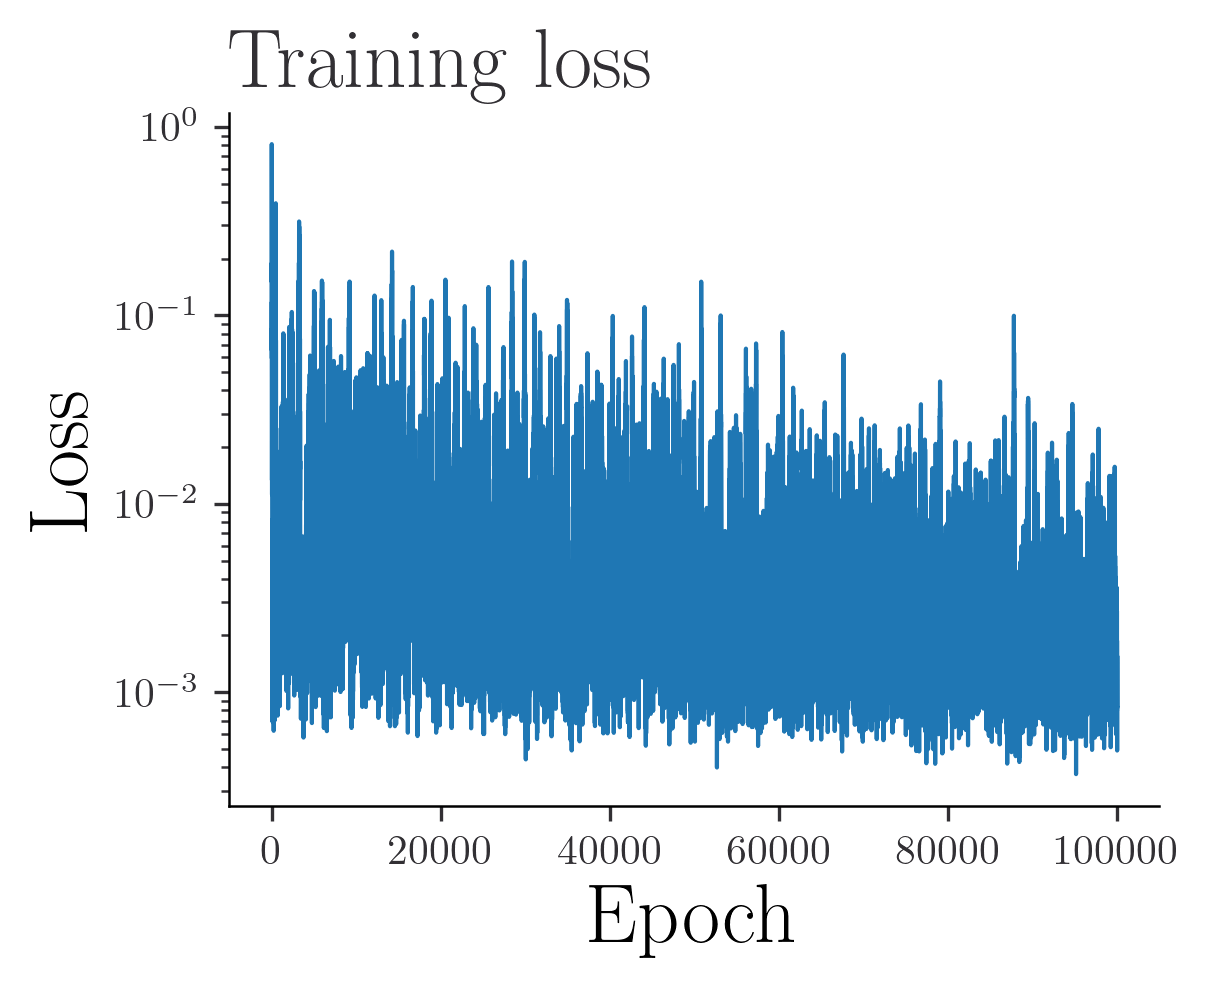

In [195]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

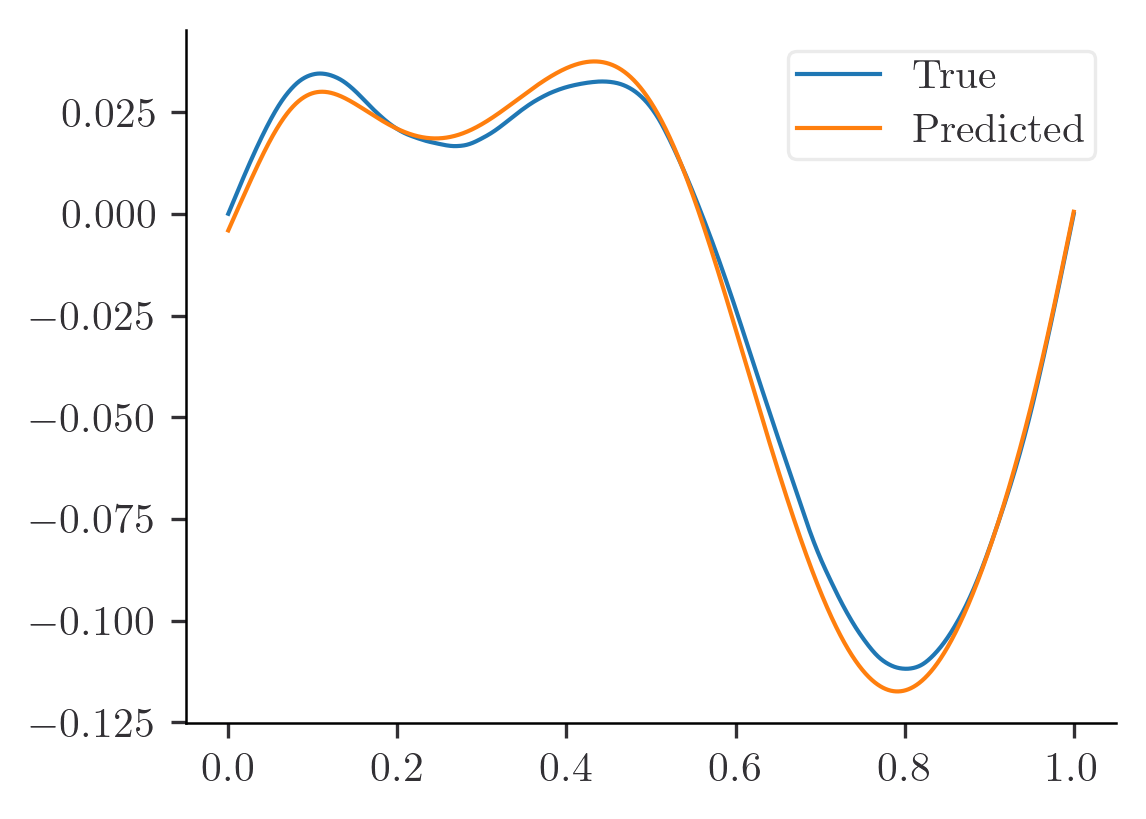

In [196]:
Psi = vmap_feature_map(x_eval, random_features)
pred = Psi@beta

fig = plt.figure(figsize=(width, height))   
plt.plot(domain_finest, u_values, label = 'True')
plt.plot(x_eval, pred, label = 'Predicted')
plt.legend()
plt.show()

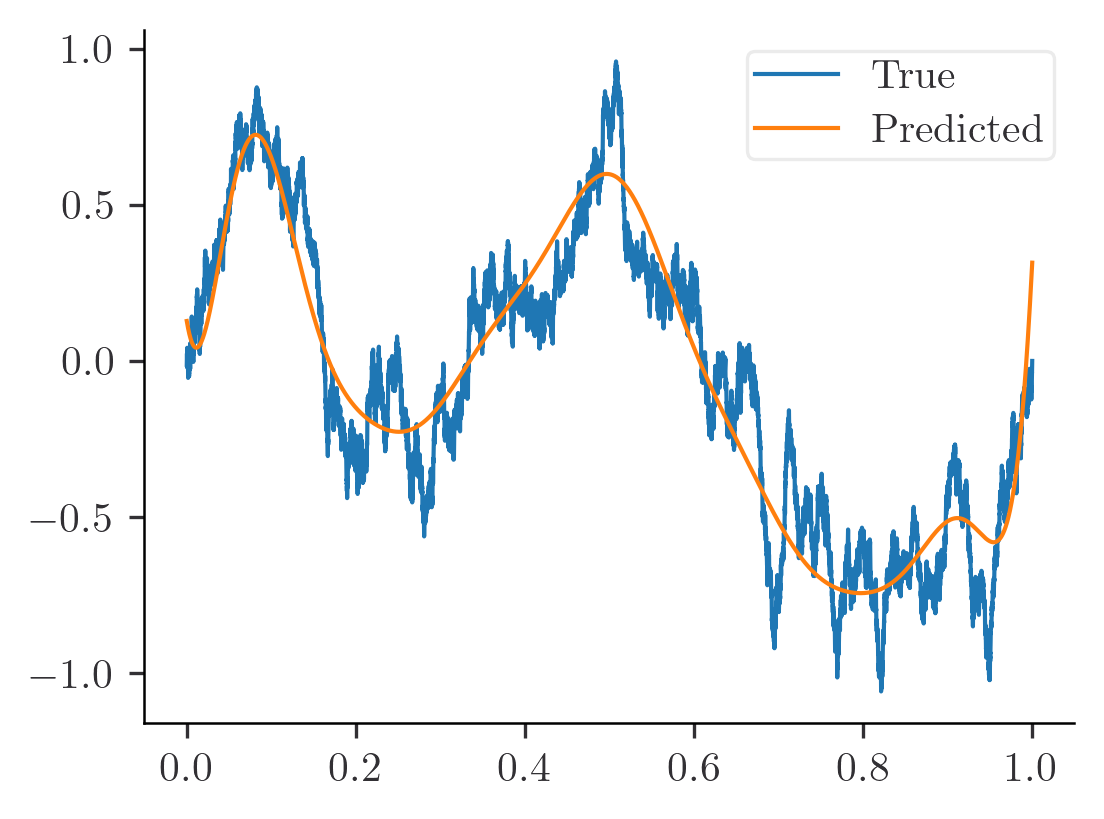

In [197]:
pred_L = L_psi@beta

fig = plt.figure(figsize=(width, height))   
plt.plot(domain_finest, f_values, label = 'True')
plt.plot(x_eval, pred_L, label = 'Predicted')
plt.legend()
plt.show()